<a href="https://colab.research.google.com/github/shubin023/generative_ai/blob/main/pset2_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')


# b. MNIST Data Loader

In [2]:

def binarize_image(tensor):
    return (tensor > 0.5).float()

tensor_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(binarize_image)
])

batch_size = 128
train_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = "./data",
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 49.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.64MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.67MB/s]


# **1. PixelCNN**


# a. Training Function

In [3]:
bce = F.binary_cross_entropy

def train(dataloader, model, optimizer, epochs):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            images = images.to(device)
            tgt = images.clone()
            pred = model(images)
            loss = bce(pred, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            avg_loss = running_loss * batch_size / len(train_dataset)
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses


# b. Masked Convolution

In [4]:
class MaskedConv2d(nn.Conv2d):
    ##################
    ### Problem 2(a): Implement MaskedConv2d
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 mask_type):

        assert mask_type in ['A', 'B']
        super().__init__(in_channels=in_channels,
                         out_channels=out_channels,
                         kernel_size=kernel_size,
                         padding=kernel_size//2,
                         device=device)

        self.register_buffer("mask", torch.zeros_like(self.weight))
        self.mask[:, :, :kernel_size // 2, :] = 1
        self.mask[:, :, kernel_size // 2, :kernel_size // 2] = 1
        if mask_type == 'B':
            self.mask[:, :, kernel_size // 2, kernel_size // 2] = 1
    def forward(self, x):
        return F.conv2d(x, self.weight * self.mask, self.bias, padding=self.padding)
    ##################


# c. Model

In [5]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, n_filters: int):
        super().__init__(n_filters)

    def forward(self, x: torch.Tensor):
        x = x.permute(0, 2, 3, 1).contiguous()
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()

In [6]:
class PixelCNN(nn.Module):
    ##################
    ### Problem 2(b): Implement PixelCNN
    def __init__(self, in_channels, out_channels, hid_channels, num_layers, kernel_size, input_shape):
        super().__init__()
        self.input_shape  = input_shape
        self.out_channels = out_channels
        self.first_layers = nn.Sequential(MaskedConv2d(in_channels, hid_channels, kernel_size, 'A'),
                                         LayerNorm(hid_channels),
                                         nn.ReLU())

        hidden_layers = []
        for _ in range(num_layers):
            hidden_layers.append(MaskedConv2d(hid_channels, hid_channels, kernel_size, 'B'))
            hidden_layers.append(LayerNorm(hid_channels))
            hidden_layers.append(nn.ReLU())

        self.hidden_layers = nn.Sequential(*hidden_layers)
        self.last_layer = MaskedConv2d(hid_channels, out_channels, kernel_size, 'B')

    def forward(self, x):
        batch_size = x.shape[0]
        out = (x.float() - 0.5) / 0.5
        out = self.first_layers(out)
        out = self.hidden_layers(out)
        out = self.last_layer(out)
        out = torch.sigmoid(out)
        return out
    ##################

# d. Training

In [ ]:
##################
### Problem 2(c): Training
epochs = 100
model = PixelCNN(1, 1, 10, 6, 7, (28, 28)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

log = train(train_loader, model, optimizer, epochs)
##################


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [1/100], Average Loss: 0.2830



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [2/100], Average Loss: 0.1680



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [3/100], Average Loss: 0.0932



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [4/100], Average Loss: 0.0877



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [5/100], Average Loss: 0.0855



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [6/100], Average Loss: 0.0845



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [7/100], Average Loss: 0.0836



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [8/100], Average Loss: 0.0831



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [9/100], Average Loss: 0.0825



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [10/100], Average Loss: 0.0822



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

# e. Evaluation (Reconstruction)

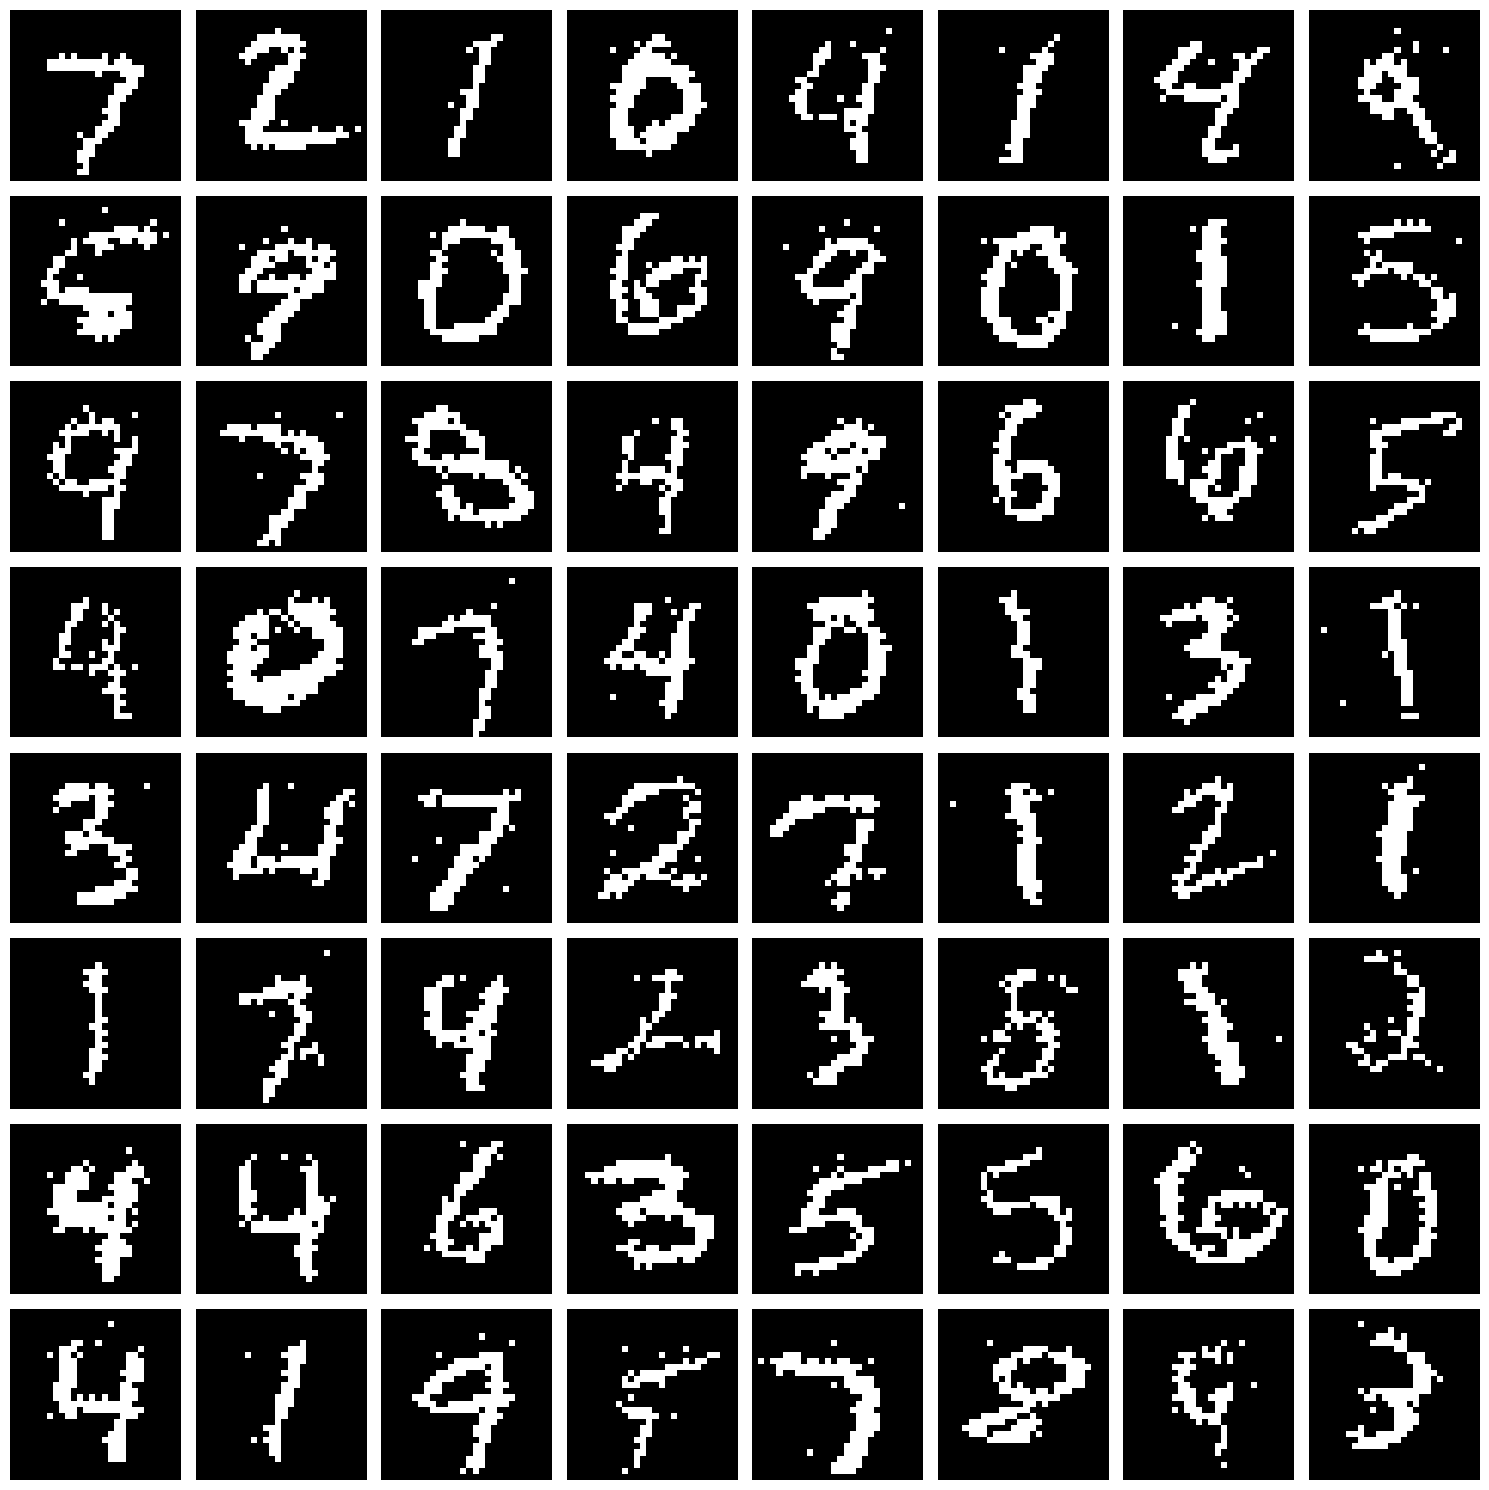

In [ ]:
H, W = 28, 28

with torch.no_grad():
  for iter, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      pred = model(images)

      for i in range(H):
          for j in range(W):
              pred[:, :, i, j] = torch.bernoulli(pred[:, :, i, j], out=pred[:, :, i, j])
      break

samples = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# f. Evaluation (Generation)

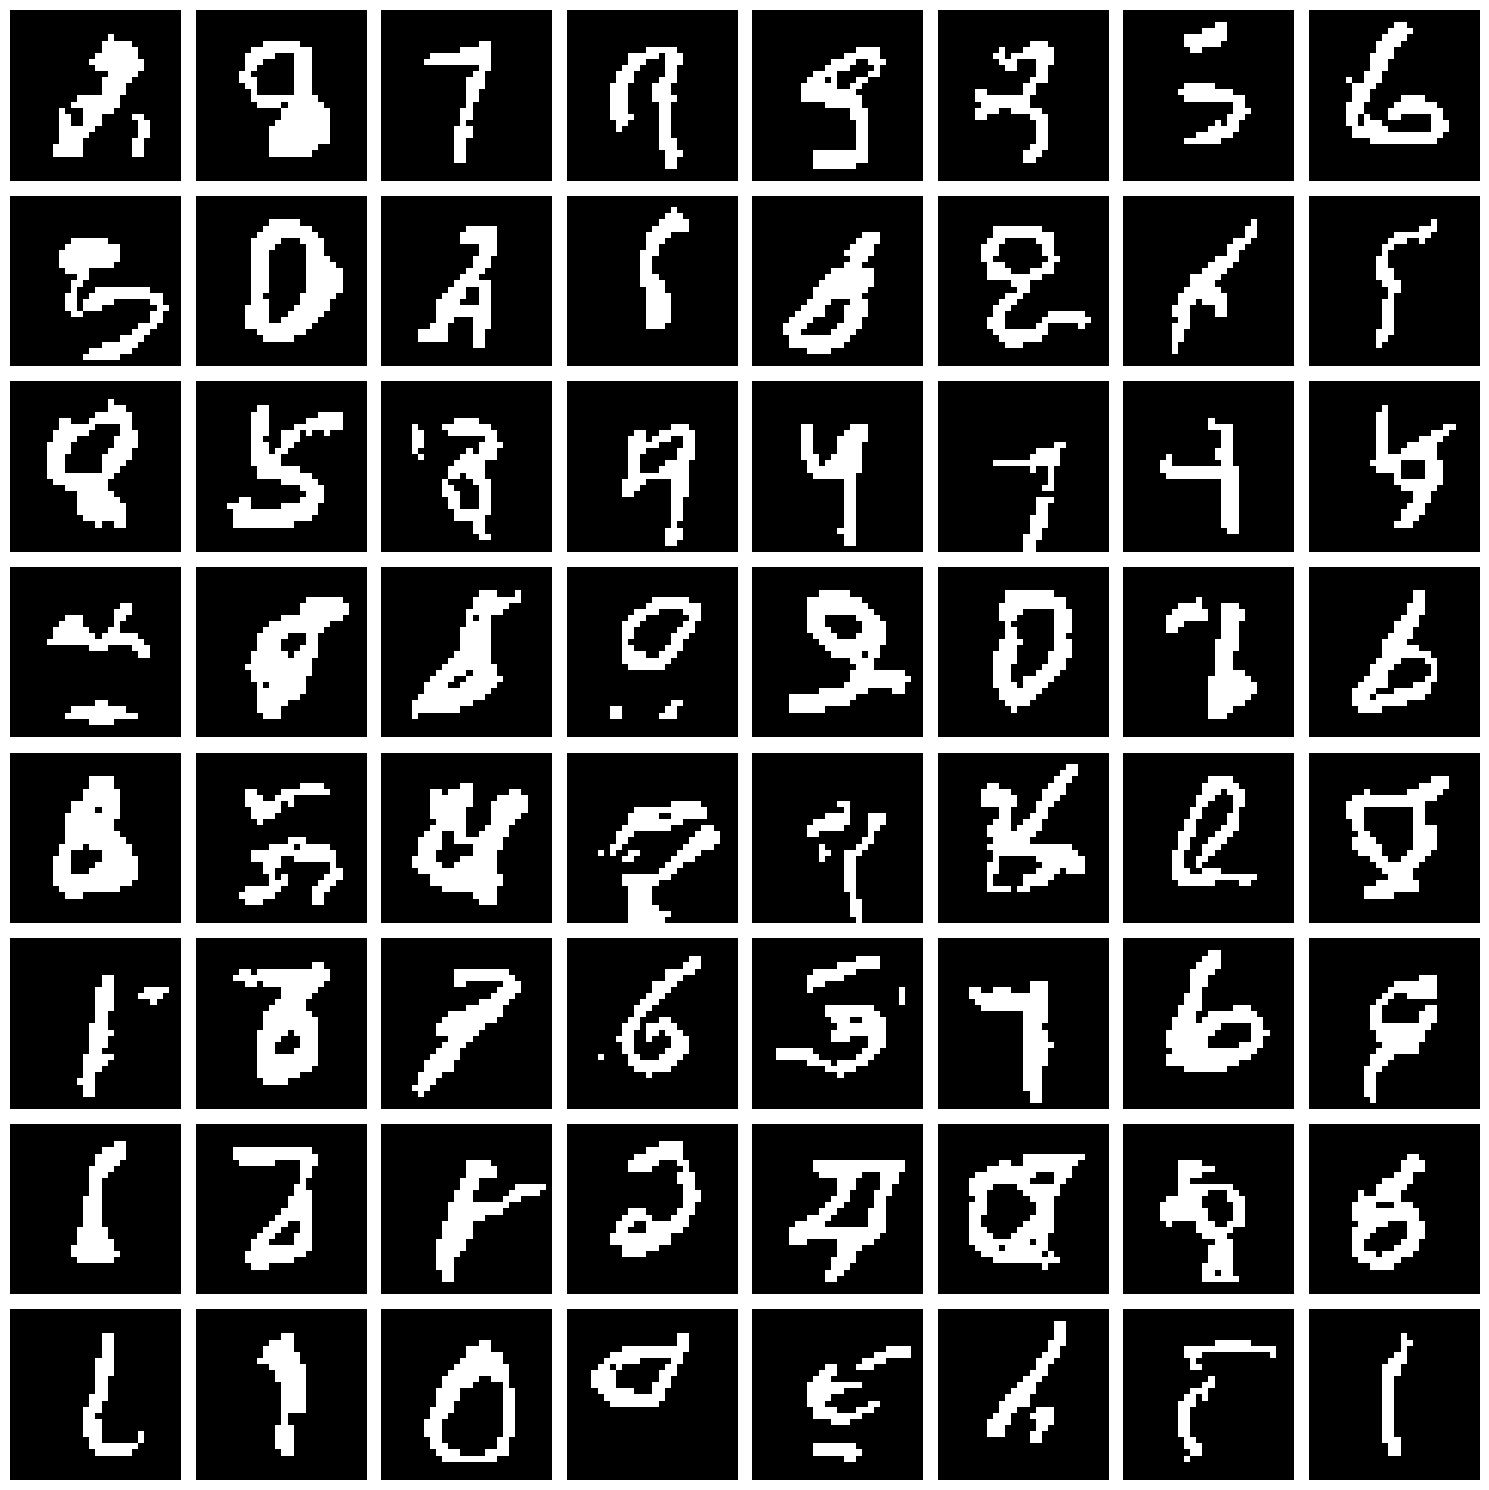

In [ ]:
samples = torch.zeros(size=(64, 1, H, W)).to(device)
with torch.no_grad():
    for i in range(H):
        for j in range(W):
            if j > 0 and i > 0:
                out = model(samples)
                samples[:, :, i, j] = torch.bernoulli(out[:, :, i, j], out=samples[:, :, i, j])

samples = samples.cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# **2. Conditional PixelCNN**


# a. Training Function

In [7]:
def train_cond(dataloader, model, optimizer, epochs, n_classes):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            images = images.to(device)
            labels = labels.to(device)
            tgt = images.clone()
            # labels = F.one_hot(labels, num_classes=n_classes).float()
            pred = model(images, labels)
            loss = bce(pred, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            avg_loss = running_loss * batch_size / len(train_dataset)
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses

# b. Conditional Masked Convolution

In [ ]:
# class ConditionalMaskedConv2d(MaskedConv2d):
#     ##################
#     ### Problem 3(b): Implement ConditionalMaskedConv2d
#     def __init__(self,
#                  in_channels,
#                  out_channels,
#                  kernel_size,
#                  mask_type):

#         super().__init__(in_channels=in_channels,
#                          out_channels=out_channels,
#                          kernel_size=kernel_size,
#                          mask_type=mask_type)
#     def forward(self, x, class_condition):
#         super().forward(x)
#     ##################

In [ ]:
# class MaskedConv2d(nn.Conv2d):
#     ##################
#     ### Problem 2(a): Implement MaskedConv2d
#     def __init__(self,
#                  in_channels,
#                  out_channels,
#                  kernel_size,
#                  mask_type):

#         assert mask_type in ['A', 'B']
#         super().__init__(in_channels=in_channels,
#                          out_channels=out_channels,
#                          kernel_size=kernel_size,
#                          padding=kernel_size//2,
#                          device=device)

#         self.register_buffer("mask", torch.zeros_like(self.weight))
#         self.mask[:, :, :kernel_size // 2, :] = 1
#         self.mask[:, :, kernel_size // 2, :kernel_size // 2] = 1
#         if mask_type == 'B':
#             self.mask[:, :, kernel_size // 2, kernel_size // 2] = 1
#     def forward(self, x):
#         return F.conv2d(x, self.weight * self.mask, self.bias, padding=self.padding)
#     ##################


# c. Model

In [11]:
class ConditionalPixelCNN(nn.Module):
    ##################
    ### Problem 3(b): Implement ConditionalPixelCNN
    def __init__(self,  in_channels, out_channels, hid_channels, num_layers, kernel_size, input_shape, num_classes, emb_size=64):
        super().__init__()
        self.input_shape  = input_shape
        self.out_channels = out_channels
        self.hid_channels = hid_channels
        self.label_emb = nn.Embedding(num_classes, emb_size)
        self.label_linear_hid = nn.Linear(emb_size, hid_channels)
        self.label_linear_out = nn.Linear(emb_size, out_channels)
        self.net = nn.ModuleList()
        self.net.extend([MaskedConv2d(in_channels, hid_channels, kernel_size, 'A'),
                           LayerNorm(hid_channels),
                           nn.ReLU()])
        for _ in range(num_layers):
            self.net.append(MaskedConv2d(hid_channels, hid_channels, kernel_size, 'B'))
            self.net.append(LayerNorm(hid_channels))
            self.net.append(nn.ReLU())

        self.last_layer = MaskedConv2d(hid_channels, out_channels, kernel_size, 'B')

    def forward(self, x, labels):
        batch_size = x.shape[0]
        out = (x.float() - 0.5) / 0.5
        label_emb = self.label_emb(labels)
        label_emb_hid = self.label_linear_hid(label_emb).view(batch_size, self.hid_channels, 1, 1)
        label_emb_out = self.label_linear_out(label_emb).view(batch_size, self.out_channels, 1, 1)
        for layer in self.net:
            out = layer(out)
            if isinstance(layer, MaskedConv2d):
                out += label_emb_hid
        out = self.last_layer(out) + label_emb_out
        out = torch.sigmoid(out)
        return out
    ##################

# d. Training

In [12]:
##################
epochs = 100
### Problem 3(c): Training
n_classes = 10
model = ConditionalPixelCNN(1, 1, 10, 6, 7, (28, 28), n_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

log = train_cond(train_loader, model, optimizer, epochs, n_classes)
##################


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [1/100], Average Loss: 0.2641



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [2/100], Average Loss: 0.2151



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [3/100], Average Loss: 0.2053



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [4/100], Average Loss: 0.1801



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [5/100], Average Loss: 0.1014



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [6/100], Average Loss: 0.0861



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [7/100], Average Loss: 0.0827



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [8/100], Average Loss: 0.0813



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [9/100], Average Loss: 0.0803



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [10/100], Average Loss: 0.0795



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

# e. Evaluation (Reconstruction)

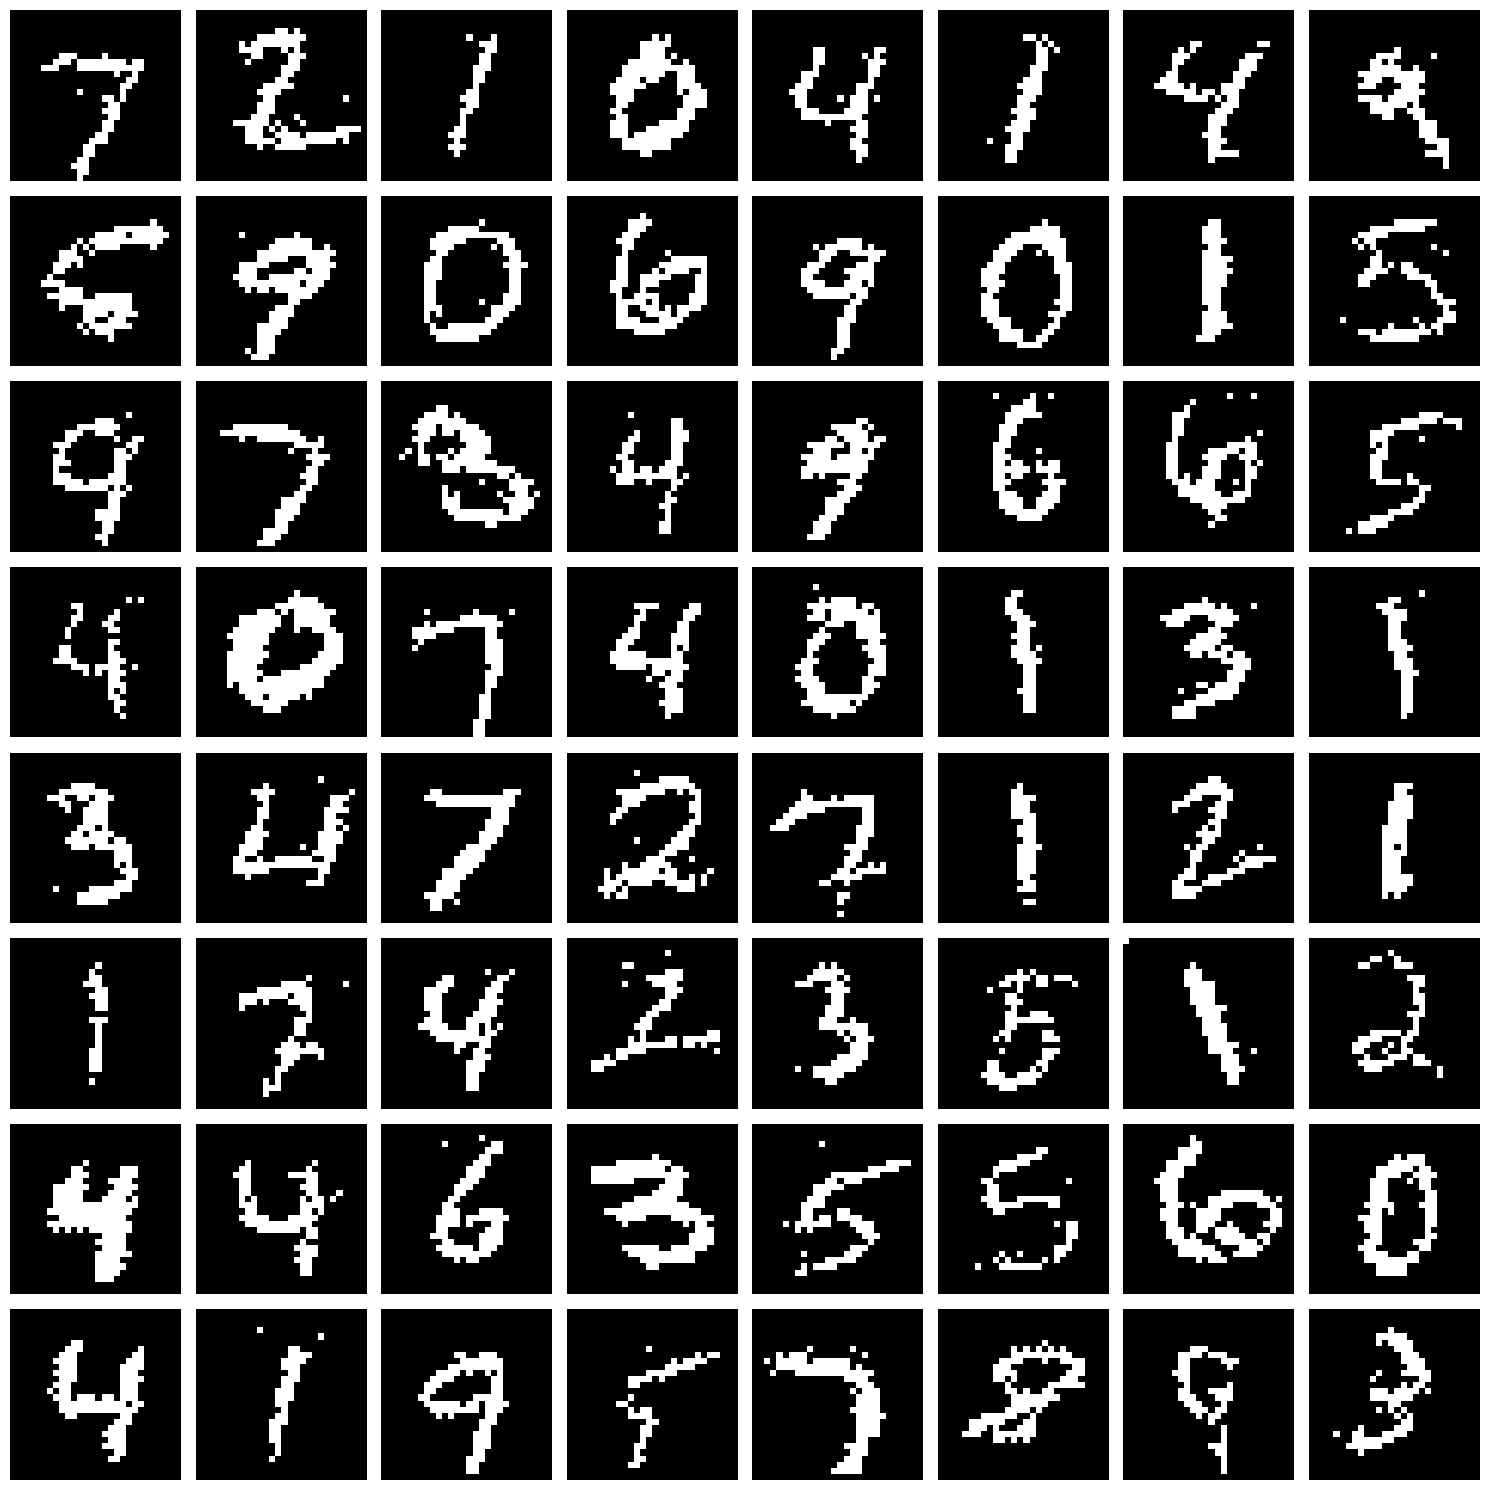

In [13]:
H, W = 28, 28

with torch.no_grad():
  for iter, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      labels = labels.to(device)
      # labels = F.one_hot(labels, num_classes=n_classes).float()
      pred = model(images, labels)

      for i in range(H):
          for j in range(W):
              pred[:, :, i, j] = torch.bernoulli(pred[:, :, i, j], out=pred[:, :, i, j])
      break

samples = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# f. Evaluation (Generation)

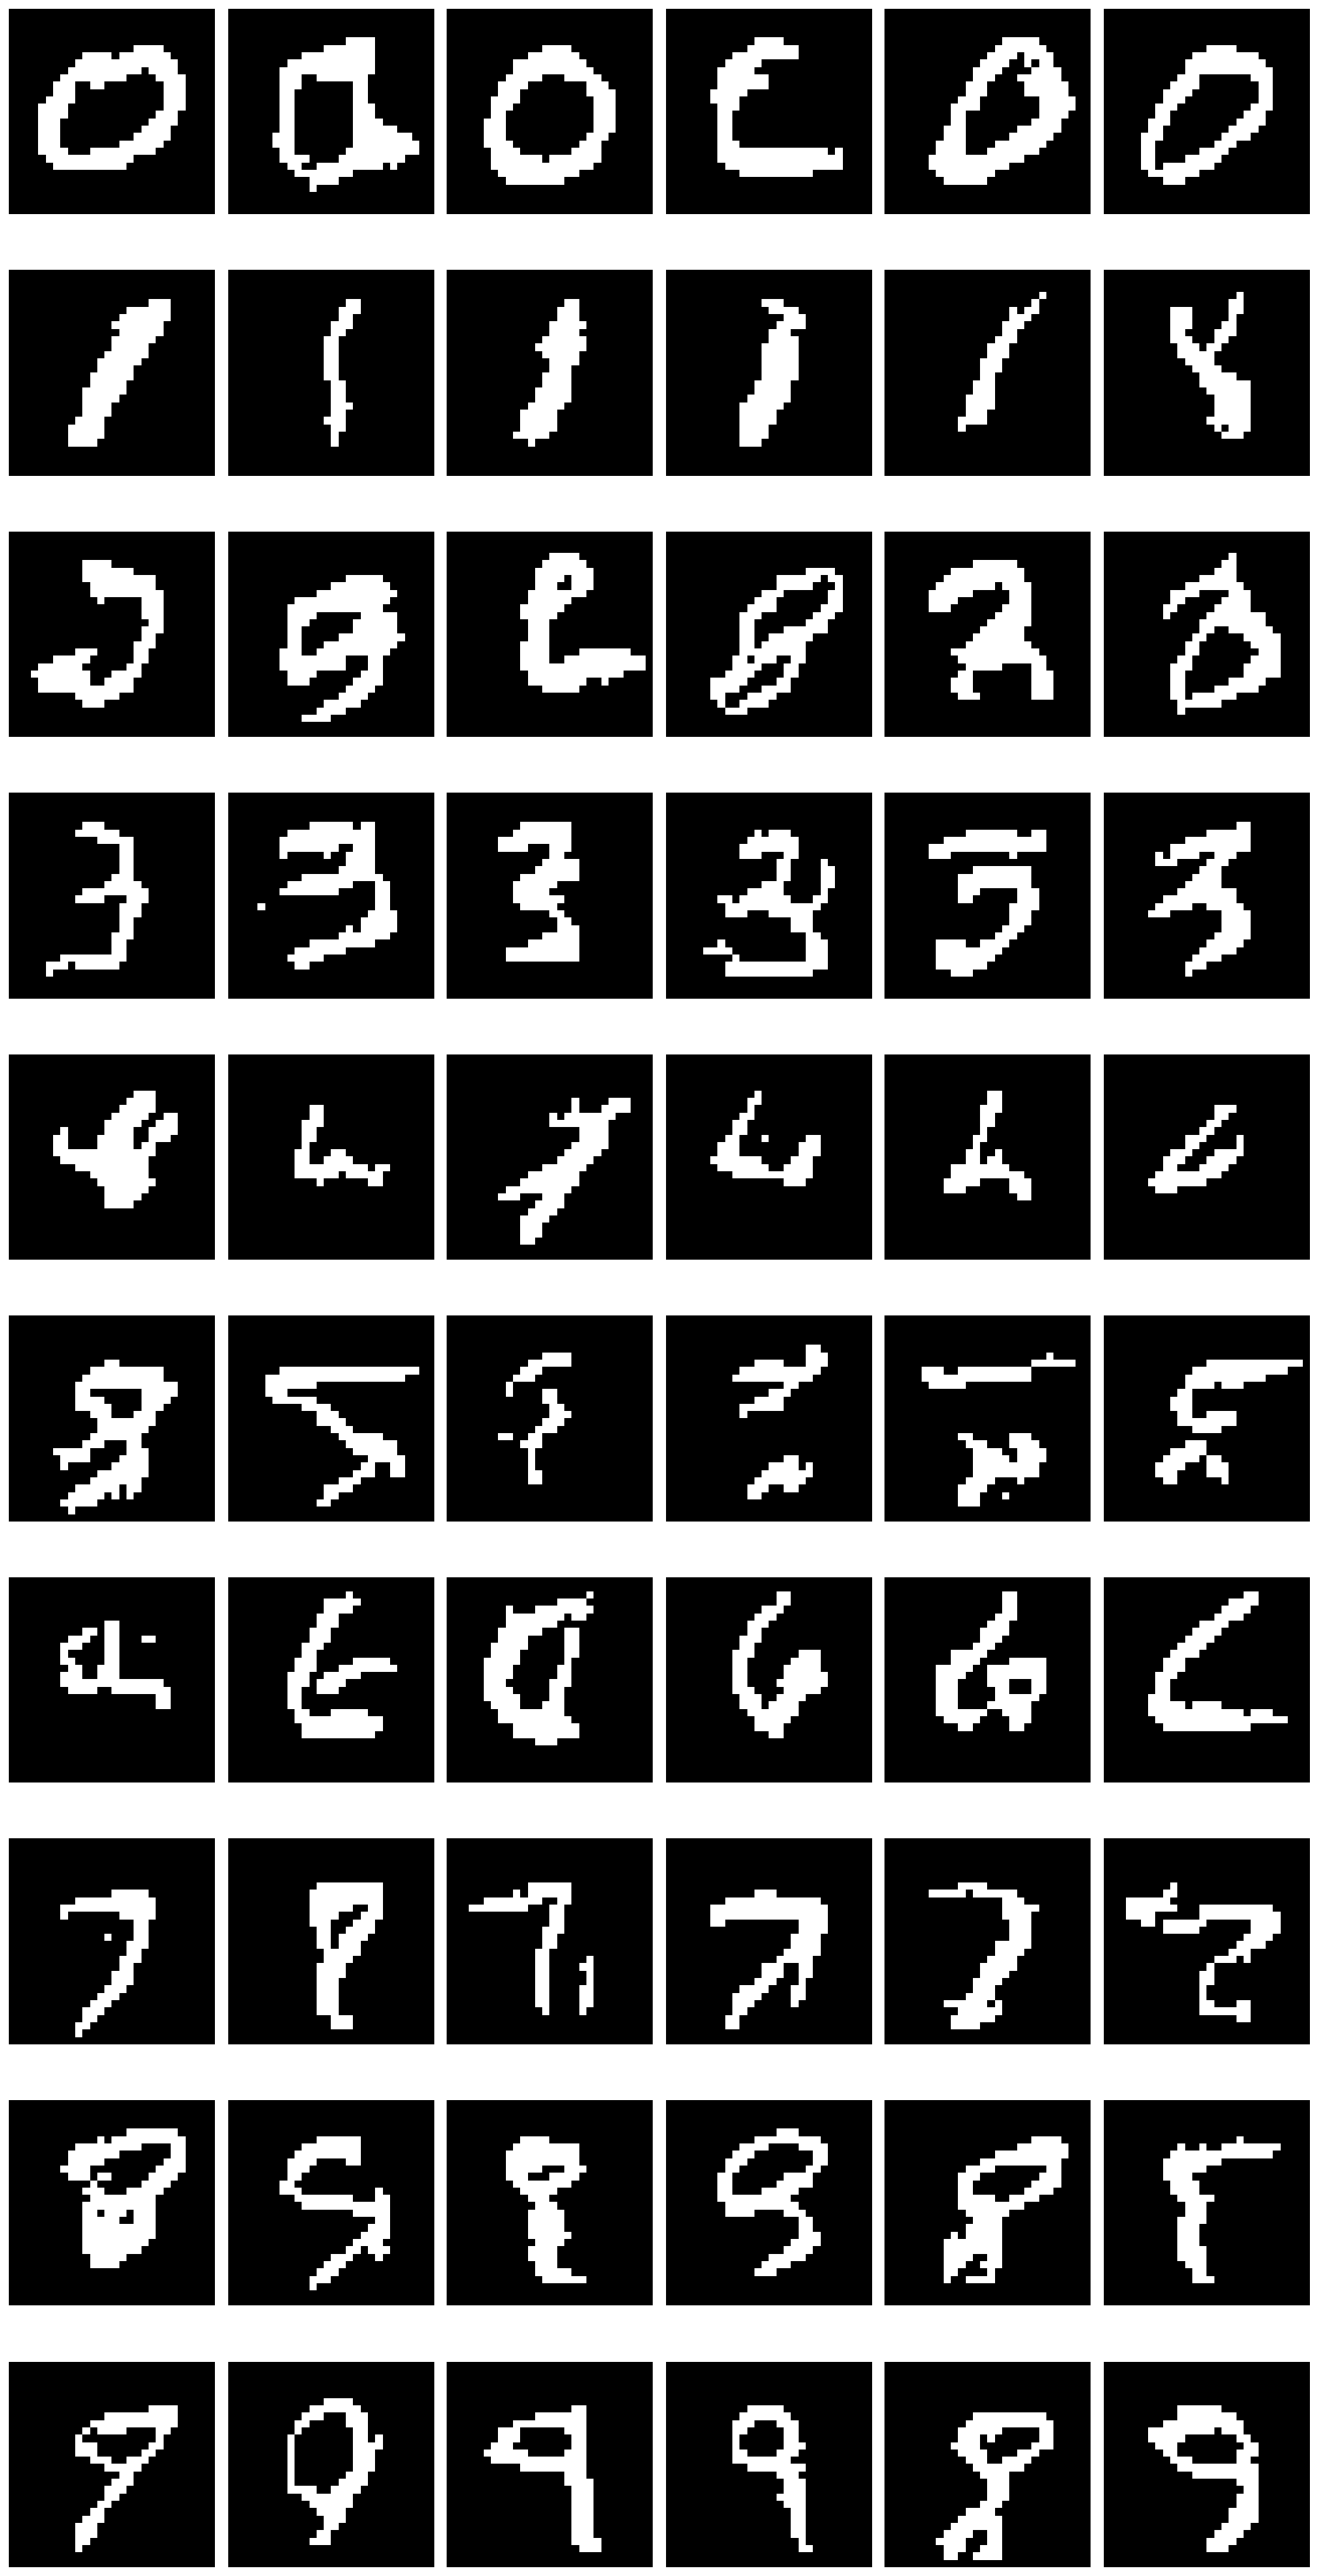

In [14]:
samples = torch.zeros(size=(60, 1, H, W)).to(device)
sample_classes = torch.tensor(np.sort(np.array([np.arange(n_classes)] * 6).flatten())).to(device)
# sample_classes = F.one_hot(torch.tensor(sample_classes), num_classes=n_classes).to(device).float()

with torch.no_grad():
    for i in range(H):
        for j in range(W):
            if j > 0 and i > 0:
                out = model(samples, sample_classes)
                samples[:, :, i, j] = torch.bernoulli(out[:, :, i, j], out=samples[:, :, i, j])

samples = samples.cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(10, 6, figsize=(15, 30))

for i in range(60):
    sample = samples[i]
    row, col = divmod(i, 6)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()